In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit

from keras.layers import LSTM, Dense, Input, Bidirectional
from keras.models import Sequential, Model
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_row', 300)
pd.set_option('display.max_columns', 100)

# DATA PREPROCESS

In [3]:

url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
y = pd.read_csv(url,index_col=0,parse_dates=[0])
y = pd.DataFrame(y)
y

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZWE,Africa,Zimbabwe,2021-06-19,41628.0,293.0,253.714,1666.0,10.0,4.857,2800.794,19.713,17.070,112.091,0.673,0.327,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1133920.0,701348.0,432572.0,2523.0,4360.0,7.63,4.72,2.91,293.0,67.59,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
ZWE,Africa,Zimbabwe,2021-06-20,41779.0,151.0,260.000,1672.0,6.0,5.714,2810.954,10.160,17.493,112.495,0.404,0.384,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1138733.0,703065.0,435668.0,4813.0,4525.0,7.66,4.73,2.93,304.0,67.59,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
ZWE,Africa,Zimbabwe,2021-06-21,42195.0,416.0,302.571,1685.0,13.0,7.143,2838.943,27.989,20.357,113.369,0.875,0.481,1.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1140852.0,704001.0,436851.0,2119.0,4664.0,7.68,4.74,2.94,314.0,67.59,14862927.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.57

In [4]:
y = y.fillna(0)
y['date'] = y['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))


In [5]:
y.head()

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,0.0,0.0,0.0,0.0,0.026,0.026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.511,0.0
AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,0.0,0.0,0.0,0.0,0.026,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.511,0.0
AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,0.0,0.0,0.0,0.0,0.026,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.511,0.0
AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,0.0,0.0,0.0,0.0,0.026,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.511,0.0
AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,0.0,0.0,0.0,0.0,0.026,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.511,0.0


In [6]:
y = y.drop(['tests_units'],axis=1)

In [7]:
y_kor = y[y.index == "KOR"]
y_usa = y[y.index == "USA"]

In [8]:
y_temp_kor = y_kor.iloc[:, 6:]
y_out_kor = []
for col in y_temp_kor.columns.tolist():
    if(type(y_temp_kor[col]) != "str"):
        tau, p_value = stats.kendalltau(y_kor['new_cases'], y_temp_kor[col])
        y_out_kor.append([np.abs(tau), p_value, col])

In [9]:
y_temp_usa = y_usa.iloc[:, 6:]
y_out_usa = []
for col in y_temp_usa.columns.tolist():
    if(type(y_temp_usa[col]) != "str"):
        tau, p_value = stats.kendalltau(y_usa['new_cases'], y_temp_usa[col])
        y_out_usa.append([np.abs(tau), p_value, col])

In [10]:
def Sort(sub_li):
    return(sorted(sub_li, key = lambda x: x[0])) 

In [19]:
Sort(y_out_kor)

[[0.0779568960991254, 0.02509692643088223, 'excess_mortality'],
 [0.2587283764885457, 2.2171648423184388e-18, 'reproduction_rate'],
 [0.28916834997576596, 1.9304328757362883e-21, 'stringency_index'],
 [0.38852896960945077,
  1.9429631296630427e-29,
  'people_fully_vaccinated_per_hundred'],
 [0.39241035571716193, 3.578457726925478e-30, 'people_fully_vaccinated'],
 [0.4202868740692184, 4.8091915763239806e-35, 'total_vaccinations'],
 [0.4202868740692184, 4.8091915763239806e-35, 'people_vaccinated'],
 [0.4204423765638546, 4.623726007448135e-35, 'total_vaccinations_per_hundred'],
 [0.42049823973400785, 4.563454393030848e-35, 'people_vaccinated_per_hundred'],
 [0.420799218202494, 2.7351616282349097e-35, 'new_vaccinations_smoothed'],
 [0.4208301974761415,
  2.7349278949242643e-35,
  'new_vaccinations_smoothed_per_million'],
 [0.4216724690702799, 3.632197425192262e-35, 'new_vaccinations'],
 [0.459859446027112, 1.699455409151554e-49, 'new_deaths'],
 [0.459859446027112, 1.699455409151554e-49, 'n

In [20]:
Sort(y_out_usa)

[[0.001239991756279201, 0.970335080829329, 'people_fully_vaccinated'],
 [0.001239991756279201,
  0.970335080829329,
  'people_fully_vaccinated_per_hundred'],
 [0.02373216932717685, 0.49539264748012457, 'excess_mortality'],
 [0.047251561901356286, 0.15364220249766627, 'people_vaccinated'],
 [0.047251561901356286, 0.15364220249766627, 'people_vaccinated_per_hundred'],
 [0.05051329761672433, 0.12700635180408415, 'total_vaccinations'],
 [0.05051329761672433, 0.12700635180408415, 'total_vaccinations_per_hundred'],
 [0.06495358395292206, 0.064757133791688, 'weekly_hosp_admissions'],
 [0.06495358395292206,
  0.064757133791688,
  'weekly_hosp_admissions_per_million'],
 [0.07956309716217555, 0.007400135133594275, 'tests_per_case'],
 [0.12710107677373697, 0.00013384996230797475, 'new_vaccinations'],
 [0.17448090847700712,
  1.1150031092962215e-07,
  'new_vaccinations_smoothed_per_million'],
 [0.1744895315819979, 1.1131963734979576e-07, 'new_vaccinations_smoothed'],
 [0.19923771088730519, 2.00577

In [13]:
y_kor = y_kor.drop(["total_cases", "new_cases_smoothed", "continent", "location", "excess_mortality", "reproduction_rate","stringency_index","total_cases_per_million", "new_cases_smoothed_per_million","new_cases_per_million","icu_patients","icu_patients_per_million","hosp_patients","hosp_patients_per_million", "weekly_icu_admissions", "weekly_icu_admissions_per_million", "weekly_hosp_admissions", "weekly_hosp_admissions_per_million", 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index'], axis=1)


In [14]:
y_usa = y_usa.drop(["total_cases", "new_cases_smoothed","continent", "location", "excess_mortality", "reproduction_rate","stringency_index","total_cases_per_million", "new_cases_smoothed_per_million","new_cases_per_million","icu_patients","icu_patients_per_million","hosp_patients","hosp_patients_per_million", "weekly_icu_admissions", "weekly_icu_admissions_per_million", "weekly_hosp_admissions", "weekly_hosp_admissions_per_million", 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index'], axis=1)


In [15]:
y_kor = y_kor.iloc[:-1,:]
y_kor

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,
KOR,2020-01-21,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,11.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
KOR,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,5.0,16.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
KOR,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
KOR,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,25.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
KOR,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KOR,2021-06-18,482.0,1997.0,1.0,2.143,38.951,0.020,0.042,31694.0,10168211.0,198.330,0.618,27271.0,0.532,0.017,57.9,0.0,0.0,0.0,0.0,423495.0,0.00,0.00,0.00,8260.0
KOR,2021-06-19,429.0,2002.0,5.0,2.429,39.049,0.098,0.047,26222.0,10194433.0,198.841,0.511,25157.0,0.491,0.019,53.8,0.0,0.0,0.0,0.0,398825.0,0.00,0.00,0.00,7779.0
KOR,2021-06-20,357.0,2004.0,2.0,2.286,39.088,0.039,0.045,10139.0,10204572.0,199.039,0.198,25169.0,0.491,0.018,54.5,17946801.0,15014819.0,4047846.0,0.0,444627.0,35.01,29.29,7.90,8672.0


In [16]:
y_usa = y_usa.iloc[:-1,:]
y_usa

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million
iso_code,,,,,,,,,,,,,,,,,,,,,,,,,
USA,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
USA,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
USA,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
USA,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
USA,2020-01-26,3.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USA,2021-06-18,20608.0,601571.0,593.0,301.571,1817.421,1.792,0.911,379999.0,461862544.0,1395.344,1.148,496530.0,1.5,0.022,45.5,316048776.0,176290249.0,148459003.0,1079390.0,1362712.0,94.50,52.71,44.39,4075.0
USA,2021-06-19,8520.0,601741.0,170.0,285.857,1817.934,0.514,0.864,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317117797.0,176737141.0,149125164.0,1069021.0,1286438.0,94.82,52.85,44.59,3847.0
USA,2021-06-20,3892.0,601824.0,83.0,281.857,1818.185,0.251,0.852,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317966408.0,177088290.0,149667646.0,848611.0,1234838.0,95.07,52.95,44.75,3692.0


# DATA PREPROCESS: Policy

In [17]:
import pandas as pd
url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
policy = pd.DataFrame(pd.read_csv(url,index_col=0,parse_dates=[0]))
policy = policy.drop(['CountryCode', 'RegionName','RegionCode', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex','ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 'EconomicSupportIndexForDisplay'],axis=1)
policy = policy.fillna(9) ## 9 means None


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
policy

,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard
CountryName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aruba,NAT_TOTAL,20200101,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
Aruba,NAT_TOTAL,20200102,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
Aruba,NAT_TOTAL,20200103,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
Aruba,NAT_TOTAL,20200104,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
Aruba,NAT_TOTAL,20200105,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe,NAT_TOTAL,20210620,0.0,9.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,9.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,9.0,0.0,9.0,9.0
Zimbabwe,NAT_TOTAL,20210621,0.0,9.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,9.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,9.0,0.0,9.0,9.0
Zimbabwe,NAT_TOTAL,20210622,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0


In [54]:
pol_kor = policy[policy.index=="South Korea"]
pol_kor = pol_kor.loc[pol_kor['Jurisdiction']=='NAT_TOTAL'].iloc[20:-2,:] 
pol_kor = pol_kor.drop(['Jurisdiction'], axis=1)
pol_kor

,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard
CountryName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
South Korea,20200121,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
South Korea,20200122,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
South Korea,20200123,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
South Korea,20200124,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
South Korea,20200125,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South Korea,20210618,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0
South Korea,20210619,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0
South Korea,20210620,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0


In [55]:
pol_usa = policy[policy.index=="United States"]
pol_usa=pol_usa.loc[pol_usa['Jurisdiction']=='NAT_TOTAL'].iloc[21:-2,:] 
pol_usa = pol_usa.drop(['Jurisdiction'], axis=1)
pol_usa

,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard
CountryName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
United States,20200122,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
United States,20200123,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
United States,20200124,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
United States,20200125,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
United States,20200126,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United States,20210618,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
United States,20210619,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
United States,20210620,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0


# DATA PREPROCESS: Meteorology 

## KOREA

In [20]:
w1 = pd.read_csv("w1.csv")
w2 = pd.read_csv("w2.csv")

In [21]:
weather_kor = pd.concat([w1,w2],ignore_index=True)
weather_kor = weather_kor.fillna(0)

In [22]:
weather_kor = weather_kor.iloc[:,2:]

In [23]:
weather_kor['일시'] = weather_kor['일시'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M'))
weather_kor['일시'] = weather_kor['일시'].apply(lambda x: x.strftime('%Y-%m-%d'))


In [24]:
weather_kor = weather_kor.groupby(['일시']).mean().iloc[20:,:]
weather_kor

,기온(°C),강수량(mm),습도(%),일조(hr),적설(cm),지면온도(°C)
일시,,,,,,
2020-01-21,0.844868,0.000614,51.693860,0.364693,0.00136,1.107193
2020-01-22,3.157851,0.160307,67.774123,0.020833,0.00000,2.422193
2020-01-23,5.530898,0.155502,79.423856,0.157835,0.00000,5.061664
2020-01-24,4.654605,0.027939,74.022807,0.271535,0.00000,4.275658
2020-01-25,5.179254,0.015263,78.046491,0.053333,0.00000,4.545000
...,...,...,...,...,...,...
2021-06-18,20.770746,0.129430,89.288596,0.028246,0.00000,22.718070
2021-06-19,22.110000,0.000000,75.495175,0.446360,0.00000,26.506886
2021-06-20,22.588509,0.000395,71.231579,0.438070,0.00000,26.991667


## United Statesof America

In [25]:
w3 = pd.read_csv("w_us1.csv")
w4 = pd.read_csv("w_us2.csv")

In [26]:
weather_usa = pd.concat([w3,w4],ignore_index=True)
weather_usa = weather_usa.drop(["강수량", "지점명",'지점'], axis=1)
weather_usa = weather_usa.fillna(0)
weather_usa

,일시,습도,풍속,현지기압,기온
0,2020-01-01 0:00,66.4,4.0,1016.3,23.3
1,2020-01-01 3:00,49.1,4.0,1017.3,21.1
2,2020-01-01 6:00,62.6,0.0,1016.3,17.2
3,2020-01-01 9:00,75.5,3.0,1015.9,18.3
4,2020-01-01 12:00,64.6,4.0,1016.6,16.7
...,...,...,...,...,...
40971,2021-06-20 0:00,43.1,7.0,1001.3,23.9
40972,2021-06-20 12:00,80.6,9.0,1000.6,15.0
40973,2021-06-21 0:00,39.4,8.0,997.9,27.2
40974,2021-06-22 0:00,32.7,5.0,993.9,31.1


In [27]:
weather_usa['일시'] = weather_usa['일시'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M'))
weather_usa['일시'] = weather_usa['일시'].apply(lambda x: x.strftime('%Y-%m-%d'))


In [28]:
weather_usa = weather_usa.groupby(['일시']).mean().iloc[21:,:]
weather_usa

,습도,풍속,현지기압,기온
일시,,,,
2020-01-22,65.558594,7.109375,1007.415625,1.947656
2020-01-23,62.528125,4.953125,1003.976562,5.356250
2020-01-24,63.800781,5.609375,1002.466406,7.562500
2020-01-25,69.702344,7.265625,998.768750,8.385937
2020-01-26,74.949219,8.460938,994.538281,8.107031
...,...,...,...,...
2021-06-18,38.707143,7.285714,997.775000,27.167857
2021-06-19,58.209524,7.547619,993.652381,26.009524
2021-06-20,59.037778,7.688889,991.722222,26.500000


# DATA GENERATION: Holidays

In [29]:
# Checker if holiday
def gen_holiday_checker(dates, holidays):
    out = []
    for date in dates:
        if date in holidays:
            out.append(1)
        else:
            out.append(0)
    
    return out   

## KOREA

In [30]:
days = pd.DataFrame(pd.date_range(start='2020-01-01', end='2021-06-22'), columns = ["date"])


In [31]:
hol_kor_tmp = days["date"].copy().dt.strftime('%m-%d')
holidays_kor = ["01-01", "01-24", "01-25", "01-26", "01-27", "03-01", "04-15", "04-30","05-05","06-06",'08-15','08-17','09-30','10-01','10-02','10-03','10-09','12-25']

In [32]:
list_hol_kor = pd.DataFrame(gen_holiday_checker(hol_kor_tmp, holidays_kor), columns = ["is_holiday"])
holiday_kor = pd.concat([days, list_hol_kor], axis=1)
holiday_kor["date"] = holiday_kor["date"].dt.strftime('%Y-%m-%d')

In [33]:
holiday_kor=holiday_kor.iloc[20:,:]
holiday_kor

,date,is_holiday
20,2020-01-21,0
21,2020-01-22,0
22,2020-01-23,0
23,2020-01-24,1
24,2020-01-25,1
...,...,...
534,2021-06-18,0
535,2021-06-19,0
536,2021-06-20,0
537,2021-06-21,0


## United States of Amierca

In [34]:
hol_usa_tmp = days["date"].copy().dt.strftime('%Y-%m-%d')
holidays_usa = ['2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25','2020-07-03', '2020-09-07', '2020-10-12', '2020-11-11', '2020-11-26', '2020-12-25', "2021-01-01", "2021-01-18", "2021-02-15", "2021-05-31", '2021-07-04', '2021-09-06', '2021-10-11','2021-11-11', '2021-11-25', '2021-12-25']

In [35]:
list_hol_usa = pd.DataFrame(gen_holiday_checker(hol_usa_tmp, holidays_usa), columns = ["is_holiday"])
holiday_usa = pd.concat([days, list_hol_usa], axis=1)
holiday_usa["date"] = holiday_usa["date"].dt.strftime('%Y-%m-%d')


In [36]:
holiday_usa=holiday_usa.iloc[21:,:]
holiday_usa

,date,is_holiday
21,2020-01-22,0
22,2020-01-23,0
23,2020-01-24,0
24,2020-01-25,0
25,2020-01-26,0
...,...,...
534,2021-06-18,0
535,2021-06-19,0
536,2021-06-20,0
537,2021-06-21,0


# DATA CONCATENATION 

## KOREA

In [58]:
data_kor = pd.concat([y_kor.reset_index(drop=True), pol_kor.reset_index(drop=True).iloc[:,1:], weather_kor.reset_index(drop=True), holiday_kor["is_holiday"].reset_index(drop=True)], axis = 1)
data_kor

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,기온(°C),강수량(mm),습도(%),일조(hr),적설(cm),지면온도(°C),is_holiday
0,2020-01-21,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,11.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,0.844868,0.000614,51.693860,0.364693,0.00136,1.107193,0
1,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,5.0,16.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,3.157851,0.160307,67.774123,0.020833,0.00000,2.422193,0
2,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.530898,0.155502,79.423856,0.157835,0.00000,5.061664,0
3,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,25.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,4.654605,0.027939,74.022807,0.271535,0.00000,4.275658,1
4,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.179254,0.015263,78.046491,0.053333,0.00000,4.545000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,2021-06-18,482.0,1997.0,1.0,2.143,38.951,0.020,0.042,31694.0,10168211.0,198.330,0.618,27271.0,0.532,0.017,57.9,0.0,0.0,0.0,0.0,423495.0,0.00,0.00,0.00,8260.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,20.770746,0.129430,89.288596,0.028246,0.00000,22.718070,0
515,2021-06-19,429.0,2002.0,5.0,2.429,39.049,0.098,0.047,26222.0,10194433.0,198.841,0.511,25157.0,0.491,0.019,53.8,0.0,0.0,0.0,0.0,398825.0,0.00,0.00,0.00,7779.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.110000,0.000000,75.495175,0.446360,0.00000,26.506886,0
516,2021-06-20,357.0,2004.0,2.0,2.286,39.088,0.039,0.045,10139.0,10204572.0,199.039,0.198,25169.0,0.491,0.018,54.5,17946801.0,15014819.0,4047846.0,0.0,444627.0,35.01,29.29,7.90,8672.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.

In [59]:
data_kor.to_csv("data_kor.csv")

## United States of America

In [60]:
data_usa = pd.concat([y_usa.reset_index(drop=True), pol_usa.reset_index(drop=True).iloc[:,1:], weather_usa.reset_index(drop=True), holiday_usa["is_holiday"].reset_index(drop=True)], axis = 1)
data_usa

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,습도,풍속,현지기압,기온,is_holiday
0,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,65.558594,7.109375,1007.415625,1.947656,0
1,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,62.528125,4.953125,1003.976562,5.356250,0
2,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,63.800781,5.609375,1002.466406,7.562500,0
3,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,69.702344,7.265625,998.768750,8.385937,0
4,2020-01-26,3.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,74.949219,8.460938,994.538281,8.107031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,2021-06-18,20608.0,601571.0,593.0,301.571,1817.421,1.792,0.911,379999.0,461862544.0,1395.344,1.148,496530.0,1.5,0.022,45.5,316048776.0,176290249.0,148459003.0,1079390.0,1362712.0,94.50,52.71,44.39,4075.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,38.707143,7.285714,997.775000,27.167857,0
514,2021-06-19,8520.0,601741.0,170.0,285.857,1817.934,0.514,0.864,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317117797.0,176737141.0,149125164.0,1069021.0,1286438.0,94.82,52.85,44.59,3847.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,58.209524,7.547619,993.652381,26.009524,0
515,2021-06-20,3892.0,601824.0,83.0,281.857,1818.185,0.251,0.852,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317966408.0,177088290.0,149667646.0,848611.0,1234838.0,95.07,52.95,44.75,3692.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,59.037778,7.68888

In [40]:
data_usa.to_csv("data_usa.csv")

# MODELING

In [122]:
df_k = data_kor.iloc[:,1:]
df_k

,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,기온(°C),강수량(mm),습도(%),일조(hr),적설(cm),지면온도(°C),is_holiday
0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,11.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,0.844868,0.000614,51.693860,0.364693,0.00136,1.107193,0
1,0.0,0.0,0.0,0.000,0.000,0.000,0.000,5.0,16.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,3.157851,0.160307,67.774123,0.020833,0.00000,2.422193,0
2,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.530898,0.155502,79.423856,0.157835,0.00000,5.061664,0
3,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,25.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,4.654605,0.027939,74.022807,0.271535,0.00000,4.275658,1
4,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.179254,0.015263,78.046491,0.053333,0.00000,4.545000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,482.0,1997.0,1.0,2.143,38.951,0.020,0.042,31694.0,10168211.0,198.330,0.618,27271.0,0.532,0.017,57.9,0.0,0.0,0.0,0.0,423495.0,0.00,0.00,0.00,8260.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,20.770746,0.129430,89.288596,0.028246,0.00000,22.718070,0
515,429.0,2002.0,5.0,2.429,39.049,0.098,0.047,26222.0,10194433.0,198.841,0.511,25157.0,0.491,0.019,53.8,0.0,0.0,0.0,0.0,398825.0,0.00,0.00,0.00,7779.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.110000,0.000000,75.495175,0.446360,0.00000,26.506886,0
516,357.0,2004.0,2.0,2.286,39.088,0.039,0.045,10139.0,10204572.0,199.039,0.198,25169.0,0.491,0.018,54.5,17946801.0,15014819.0,4047846.0,0.0,444627.0,35.01,29.29,7.90,8672.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.588509,0.000395,71.23157

In [123]:
train_s = df_k[:-10]
test_s = df_k[-10:]
train_l = df_k[:-30]
test_l = df_k[-30:]

In [124]:
tr_x_s = train_s.iloc[:,1:]
tr_y_s = train_s.iloc[:,:1]
te_x_s = test_s.iloc[:,1:]
te_y_s = test_s.iloc[:,:1]

tr_x_l = train_l.iloc[:,1:]
tr_y_l = train_l.iloc[:,:1]
te_x_l = test_l.iloc[:,1:]
te_y_l = test_l.iloc[:,:1]

In [125]:
tr_x_s = tr_x_s.values
tr_y_s = tr_y_s.values
te_x_s = te_x_s.values
te_y_s = te_y_s.values

tr_x_l = tr_x_l.values
tr_y_l = tr_y_l.values
te_x_l = te_x_l.values
te_y_l = te_y_l.values

In [126]:
print(tr_x_s.shape)
print(tr_x_s)
print(te_x.shape)
# print("")
# print(te_y.shape)
# print(te_y)

(509, 63)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.35964912e-03
  1.10719298e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  2.42219298e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  5.06166373e+00 0.00000000e+00]
 ...
 [1.98100000e+03 2.00000000e+00 1.71400000e+00 ... 0.00000000e+00
  2.54262281e+01 0.00000000e+00]
 [1.98200000e+03 1.00000000e+00 1.57100000e+00 ... 0.00000000e+00
  2.38750439e+01 0.00000000e+00]
 [1.98500000e+03 3.00000000e+00 1.71400000e+00 ... 0.00000000e+00
  2.62373246e+01 0.00000000e+00]]
(10, 63)


In [127]:
tr_x_s_ = tr_x_s.reshape(tr_x_s.shape[0],63,1)
te_x_s_ = te_x_s.reshape(te_x_s.shape[0],63,1)
tr_x_l_ = tr_x_l.reshape(tr_x_l.shape[0],63,1)
te_x_l_ = te_x_l.reshape(te_x_l.shape[0],63,1)

In [128]:
print(tr_x_s_.shape)
print(te_x_s_.shape)

(509, 63, 1)
(10, 63, 1)


In [129]:
print(tr_x_l_.shape)
print(te_x_l_.shape)

(489, 63, 1)
(30, 63, 1)


# LSTM

## Short Term

In [130]:
K.clear_session()
model = Sequential()

model.add(LSTM(128, activation ='sigmoid', input_shape=(63,1)))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 93,749
Trainable params: 93,749
Non-trainable params: 0
____________________________________________________

In [131]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_s_, tr_y_s, epochs = 100, batch_size = 5, verbose=1, callbacks =[early_stop])

Epoch 1/100
102/102 [==============================] - 7s 61ms/step - loss: 117811.1383 - mse: 117811.1383
Epoch 2/100
102/102 [==============================] - 6s 57ms/step - loss: 81595.6269 - mse: 81595.6269
Epoch 3/100
102/102 [==============================] - 6s 61ms/step - loss: 74379.2116 - mse: 74379.2116
Epoch 4/100
102/102 [==============================] - 6s 60ms/step - loss: 72395.2280 - mse: 72395.2284
Epoch 5/100
102/102 [==============================] - 6s 60ms/step - loss: 66834.8063 - mse: 66834.8065
Epoch 6/100
102/102 [==============================] - 6s 58ms/step - loss: 67233.9213 - mse: 67233.9213
Epoch 7/100
102/102 [==============================] - 6s 56ms/step - loss: 78739.1111 - mse: 78739.1079
Epoch 8/100
  1/102 [..............................] - ETA: 5s - loss: 102059.1250 - mse: 102059.1250

In [71]:
y_pred_s = model.predict(te_x_s_)
real_s = np.concatenate((tr_y_s, te_y_s))
forecast_s = np.concatenate((tr_y_s, y_pred_s))

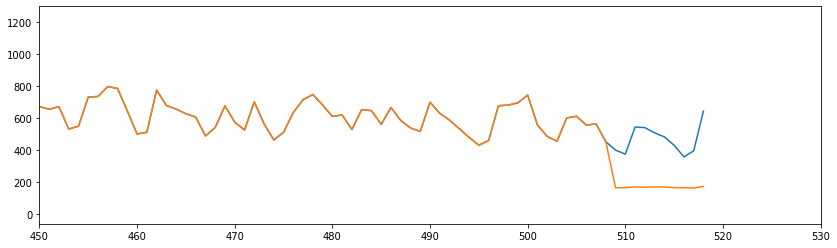

In [72]:
plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real_s, label = "real")
plt.plot(forecast_s, label = "forecast")
plt.xlim([450,530])
plt.legend
plt.show()

In [73]:
# RMSE를 살펴 봄
RMSE_LSTM_s  = np.mean(np.sqrt((y_pred_s[:9] - te_y_s[:9]) ** 2)) 
print(RMSE_LSTM_s)

281.5940992567274


## Long term

# Bidirectional LSTM

In [79]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(128, activation='tanh'), input_shape=(63,1)))
# model2.add(Dense(128))
model2.add(Dense(64))
model2.add(Dense(32))
# model2.add(Dense(32))
# model2.add(Dense(32))
# model2.add(Dense(32))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               133120    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 151,681
Trainable params: 151,681
Non-trainable params: 0
_________________________________________________________________


In [80]:
early_stop = EarlyStopping(monitor="loss", patience = 1, verbose=1)
model2.fit(tr_x_, tr_y, epochs = 100, batch_size = 5, verbose=1, callbacks =[early_stop])

Epoch 1/100
102/102 [==============================] - 8s 53ms/step - loss: 119023.7596 - mse: 119023.7607
Epoch 2/100
102/102 [==============================] - 5s 53ms/step - loss: 37752.5894 - mse: 37752.5894
Epoch 3/100
102/102 [==============================] - 5s 53ms/step - loss: 22227.9973 - mse: 22227.9980
Epoch 4/100
102/102 [==============================] - 5s 53ms/step - loss: 15584.9270 - mse: 15584.9270
Epoch 5/100
102/102 [==============================] - 5s 53ms/step - loss: 8686.5269 - mse: 8686.5269
Epoch 6/100
102/102 [==============================] - 5s 54ms/step - loss: 10044.1191 - mse: 10044.1190
Epoch 7/100
102/102 [==============================] - 5s 53ms/step - loss: 8536.6260 - mse: 8536.6262
Epoch 8/100
102/102 [==============================] - 5s 53ms/step - loss: 7503.3771 - mse: 7503.3775
Epoch 9/100
102/102 [==============================] - 5s 53ms/step - loss: 6462.9280 - mse: 6462.9280
Epoch 10/100
102/102 [==============================] - 5s 53

In [81]:
y_pred2 = model2.predict(te_x_)
real2 = np.concatenate((tr_y, te_y))
forecast2 = np.concatenate((tr_y, y_pred2))

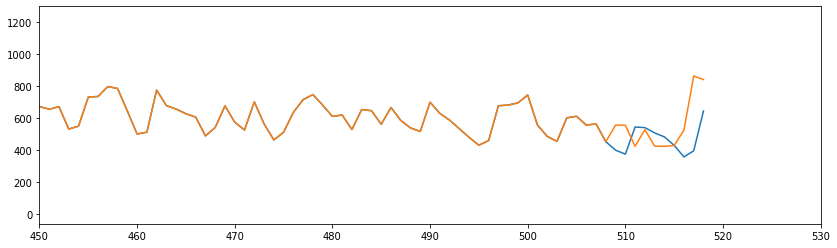

In [82]:
plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real2, label = "real")
plt.plot(forecast2, label = "forecast")
plt.xlim([450,530])
plt.legend
plt.show()

In [83]:
# RMSE를 살펴 봄
RMSE_biLSTM  = np.mean(np.sqrt((y_pred2[:9] - te_y[:9]) ** 2)) 
print(RMSE_biLSTM)

138.8689439561632


# ARIMA

In [48]:
from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [63]:
a_df_k = data_kor.iloc[:,:2]
a_df_k['date'] =  pd.to_datetime(a_df_k['date'])
a_df_k=a_df_k.set_index('date')
a_df_k

,new_cases
date,
2020-01-21,0.0
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
...,...
2021-06-18,482.0
2021-06-19,429.0
2021-06-20,357.0


In [64]:
case_by_day = a_df_k.new_cases.resample('d').sum()
split = "2021-06-14"
a_kr_train = case_by_day[:split]
a_kr_test = case_by_day[split:]
a_kr_final = a_kr_test.copy()


In [65]:
a_kr_final

date
2021-06-14    374.0
2021-06-15    544.0
2021-06-16    540.0
2021-06-17    507.0
2021-06-18    482.0
2021-06-19    429.0
2021-06-20    357.0
2021-06-21    395.0
2021-06-22    644.0
Freq: D, Name: new_cases, dtype: float64

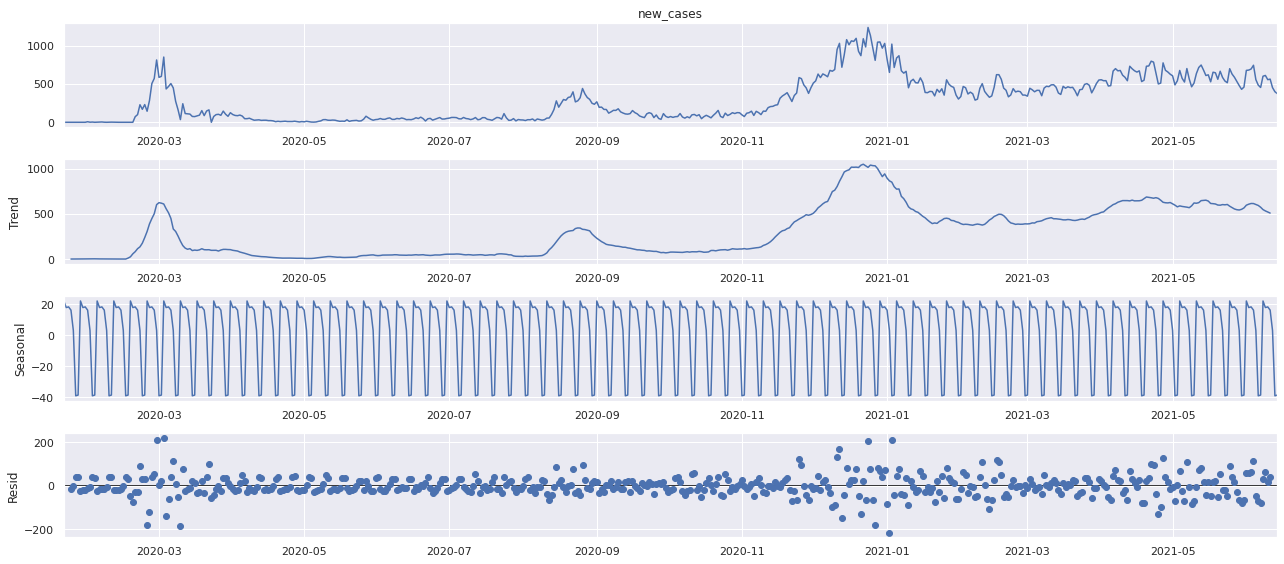

In [66]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a_kr_train, model='additive')
fig = decomposition.plot()
plt.show()

In [67]:
#p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(a_kr_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7571.240230860018
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6991.13580902608
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6575.194381349351
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6427.394312634307
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6574.6330586664035
/home/jiwon4j/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6564.287135822804
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6440.355900794486
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6404.30117282667
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6984.756827412106
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6501.3025371280855
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6220.7366881340895
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6062.105343231729
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6220.667155774243
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:6191.3495608

/home/jiwon4j/miniconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


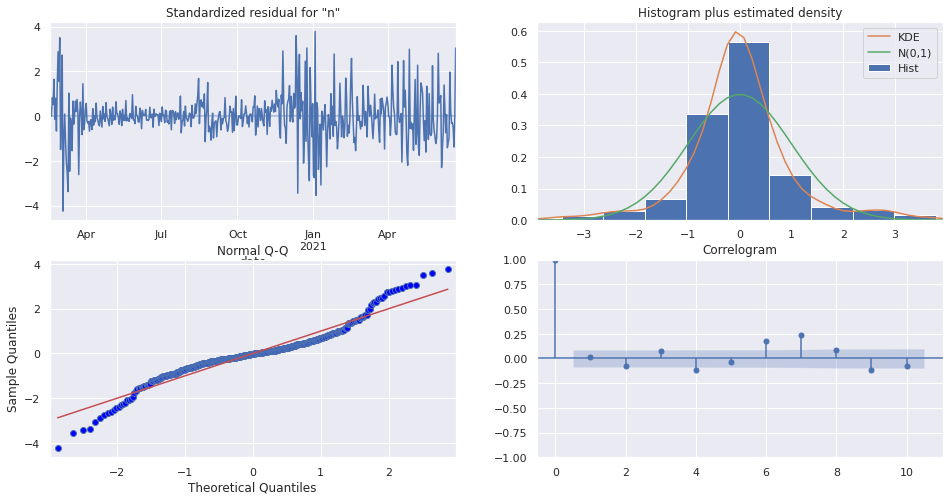

In [68]:
NEW_CASES  = sm.tsa.statespace.SARIMAX(case_by_day , order=(1, 1, 1), seasonal_order=(0, 1, 1, 12) , enforce_stationarity = False, enforce_invertibility = False)

SARIMA_results_day = NEW_CASES.fit()

SARIMA_results_day.plot_diagnostics(figsize=(16, 8))
plt.show()

In [69]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_day = SARIMA_results_day.predict(start=len(case_by_day)-10, end=len(case_by_day))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
a_kr_final['predicted'] = SARIMA_predict_day


In [70]:
# RMSE를 살펴 봄
RMSE_daily_ARIMA  = np.mean(np.sqrt((SARIMA_predict_day - a_kr_test) ** 2)) 
print(RMSE_daily_ARIMA)

72.59016289356558


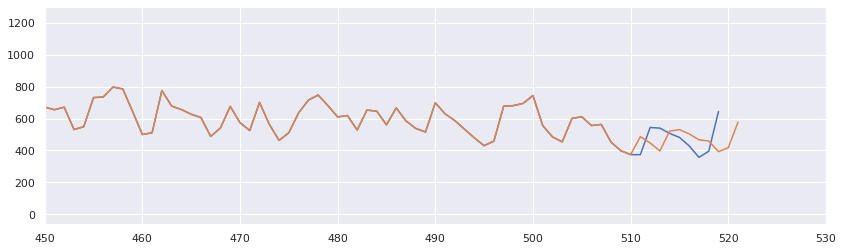

In [71]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlim([450,530])
plt.legend
plt.show()

# Vector Auto Regression (VAR)

In [17]:
data_kor = pd.read_csv("data_kor.csv", index_col = 0)
data_kor

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,기온(°C),강수량(mm),습도(%),일조(hr),적설(cm),지면온도(°C),is_holiday
0,2020-01-21,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,11.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,20200121,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,0.844868,0.000614,51.693860,0.364693,0.00136,1.107193,0
1,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,5.0,16.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,20200122,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,3.157851,0.160307,67.774123,0.020833,0.00000,2.422193,0
2,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,20200123,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.530898,0.155502,79.423856,0.157835,0.00000,5.061664,0
3,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,25.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,20200124,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,4.654605,0.027939,74.022807,0.271535,0.00000,4.275658,1
4,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,20200125,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,5.179254,0.015263,78.046491,0.053333,0.00000,4.545000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,2021-06-18,482.0,1997.0,1.0,2.143,38.951,0.020,0.042,31694.0,10168211.0,198.330,0.618,27271.0,0.532,0.017,57.9,0.0,0.0,0.0,0.0,423495.0,0.00,0.00,0.00,8260.0,20210618,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,20.770746,0.129430,89.288596,0.028246,0.00000,22.718070,0
515,2021-06-19,429.0,2002.0,5.0,2.429,39.049,0.098,0.047,26222.0,10194433.0,198.841,0.511,25157.0,0.491,0.019,53.8,0.0,0.0,0.0,0.0,398825.0,0.00,0.00,0.00,7779.0,20210619,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,0.0,9.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,3.0,2.0,0.0,0.0,3.0,1.0,3.0,1.0,2.0,1.0,9.0,22.110000,0.000000,75.495175,0.446360,0.00000,26.506886,0
516,2021-06-20,357.0,2004.0,2.0,2.286,39.088,0.039,0.045,10139.0,10204572.0,199.039,0.198,25169.0,0.491,0.018,54.5,17946801.0,15014819.0,4047846.0,0.0,444627.0,35.01,29.29,7.

In [18]:
df_temp_kor = data_kor.iloc[:, 2:]
df_out_kor = []
for col in df_temp_kor.columns.tolist():
    if(type(df_temp_kor[col]) != "str"):
        tau, p_value = stats.kendalltau(data_kor['new_cases'], df_temp_kor[col])
        df_out_kor.append([np.abs(tau), p_value, col])

In [19]:
sorted_out = Sort(df_out_kor)
sorted_out[-20:]

[[0.42020298821268925, 7.6378248881956e-35, 'new_vaccinations'],
 [0.4279399728634909, 1.20293227795676e-32, 'H7_Flag'],
 [0.44381297922859475, 2.4830791023844504e-36, 'H7_Vaccination policy'],
 [0.4620078268433285, 7.381113403853731e-50, 'new_deaths'],
 [0.4620078268433285, 7.381113403853731e-50, 'new_deaths_per_million'],
 [0.4922627854362075, 1.7766127648159855e-61, 'new_deaths_smoothed'],
 [0.4922627854362075,
  1.7766127648159855e-61,
  'new_deaths_smoothed_per_million'],
 [0.5045595357926425, 5.8218431507331794e-65, 'new_tests'],
 [0.5060498864810563, 3.2290338468323855e-65, 'new_tests_per_thousand'],
 [0.5151951054419672, 2.4298682656846477e-68, 'total_tests'],
 [0.5162252894576506, 1.4960694308763062e-68, 'total_tests_per_thousand'],
 [0.5598027959084709, 9.60937687528267e-81, 'tests_per_case'],
 [0.5883486785114631, 4.8334068318728625e-89, 'Date'],
 [0.5891215686909282, 6.937819595351103e-89, 'total_deaths'],
 [0.5891215686909282, 6.937819595351103e-89, 'total_deaths_per_milli

In [36]:
raw_kor = data_kor[['new_cases','positive_rate','H6_Facial Coverings','total_deaths_per_million','new_tests_smoothed_per_thousand']]
raw_kor

,new_cases,positive_rate,H6_Facial Coverings,total_deaths_per_million,new_tests_smoothed_per_thousand
0,0.0,0.000,0.0,0.000,0.000
1,0.0,0.000,0.0,0.000,0.000
2,0.0,0.000,0.0,0.000,0.000
3,1.0,0.000,0.0,0.000,0.000
4,0.0,0.000,0.0,0.000,0.000
...,...,...,...,...,...
514,482.0,0.017,3.0,38.951,0.532
515,429.0,0.019,3.0,39.049,0.491
516,357.0,0.018,3.0,39.088,0.491
517,395.0,0.019,9.0,39.127,0.489


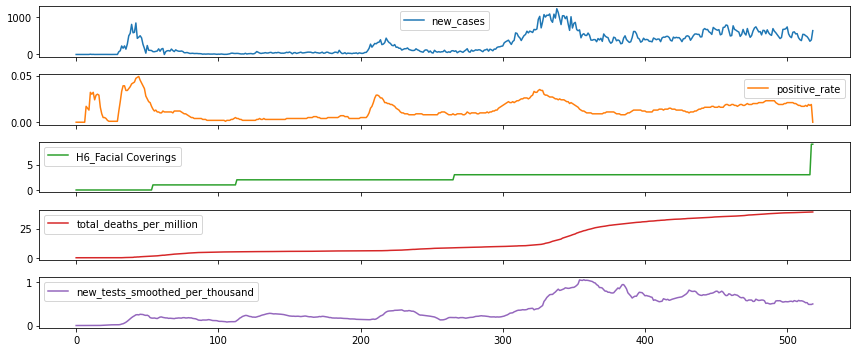

In [37]:
# 데이터 시각화
raw_kor.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [38]:
adfuller_test = adfuller(raw_kor['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.05846632381244
p-value: 0.26153994451493845


In [39]:
adfuller_test = adfuller(raw_kor['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.63121012319374
p-value: 0.0867167905410462


In [40]:
adfuller_test = adfuller(raw_kor['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.24428404966207773
p-value: 0.9746388014922993


In [41]:
adfuller_test = adfuller(raw_kor['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.9609648835810245
p-value: 0.3039464152913477


In [42]:
adfuller_test = adfuller(raw_kor['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.21874166373660278
p-value: 0.973293382548059


In [43]:
raw_kor_diff = raw_kor.diff().dropna()


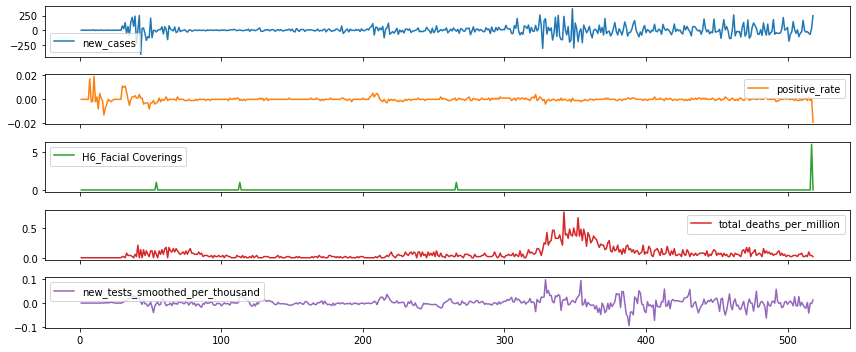

In [44]:
raw_kor_diff.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [45]:
adfuller_test = adfuller(raw_kor_diff['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.125091067226004
p-value: 8.667697652948969e-08


In [46]:
adfuller_test = adfuller(raw_kor_diff['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -5.958629330944385
p-value: 2.0643543721272526e-07


In [47]:
adfuller_test = adfuller(raw_kor_diff['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.1995496611556717
p-value: 0.02001076140204199


In [48]:
adfuller_test = adfuller(raw_kor_diff['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.8769655149098496
p-value: 0.0022110622514347985


In [49]:
adfuller_test = adfuller(raw_kor_diff['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -22.785330619401336
p-value: 0.0


In [50]:
train = raw_kor_diff.iloc[:-10,:]
test = raw_kor_diff.iloc[-10:,:]

In [51]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/home/jiwon4j/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


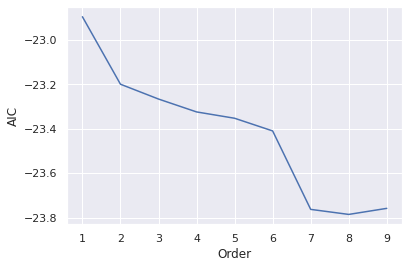

In [52]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [53]:
results = forecasting_model.fit(8)
# results.summary()

In [54]:
laaged_values = train.values[-8:]

In [56]:
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['new_cases_diff','positive_rate_diff','H6_Facial Coverings_diff','total_deaths_per_million_diff','new_tests_smoothed_per_thousand_diff'])
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff
509,-46.207028,-0.000601,0.031309,0.027031,0.005613
510,52.297160,-0.000351,-0.004117,0.045284,0.003802
511,22.718216,-0.000829,0.003218,0.039676,0.008062
512,26.051883,-0.000131,0.015161,0.026682,-0.011529
513,-13.705074,-0.000232,0.018060,0.044288,0.000608
514,-36.740395,-0.000584,0.029810,0.032106,0.002906
515,-25.258392,0.000159,0.025566,0.040254,-0.010322
516,-6.746232,0.000128,0.009061,0.045943,-0.003077
517,13.012357,-0.000102,0.007326,0.034477,-0.001304
518,32.932449,0.000174,0.003504,0.039228,-0.005531


In [57]:
forecast["new_cases_forecasted"] = raw_kor["new_cases"].iloc[-10-1] + forecast['new_cases_diff'].cumsum()
forecast["positive_rate_forecasted"] = raw_kor["positive_rate"].iloc[-10-1] + forecast['positive_rate_diff'].cumsum()
forecast["total_deaths_per_million_forecasted"] = raw_kor["total_deaths_per_million"].iloc[-10-1] + forecast['total_deaths_per_million_diff'].cumsum()
forecast["new_tests_smoothed_per_thousand_forecasted"] = raw_kor["new_tests_smoothed_per_thousand"].iloc[-10-1] + forecast['new_tests_smoothed_per_thousand_diff'].cumsum()

forecast["H6_Facial Coverings_forecasted"] = raw_kor["H6_Facial Coverings"].iloc[-10-1] + forecast['H6_Facial Coverings_diff'].cumsum()
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff,new_cases_forecasted,positive_rate_forecasted,total_deaths_per_million_forecasted,new_tests_smoothed_per_thousand_forecasted,H6_Facial Coverings_forecasted
509,-46.207028,-0.000601,0.031309,0.027031,0.005613,405.792972,0.017399,38.744031,0.589613,3.031309
510,52.297160,-0.000351,-0.004117,0.045284,0.003802,458.090132,0.017048,38.789316,0.593414,3.027192
511,22.718216,-0.000829,0.003218,0.039676,0.008062,480.808349,0.016219,38.828992,0.601476,3.030410
512,26.051883,-0.000131,0.015161,0.026682,-0.011529,506.860232,0.016088,38.855674,0.589947,3.045571
513,-13.705074,-0.000232,0.018060,0.044288,0.000608,493.155158,0.015856,38.899962,0.590555,3.063631
514,-36.740395,-0.000584,0.029810,0.032106,0.002906,456.414763,0.015272,38.932068,0.593461,3.093440
515,-25.258392,0.000159,0.025566,0.040254,-0.010322,431.156371,0.015431,38.972322,0.583139,3.119006
516,-6.746232,0.000128,0.009061,0.045943,-0.003077,424.410139,0.015559,39.018265,0.580062,3.128068
517,13.012357,-0.000102,0.007326,0.034477,-0.001304,437.422496,0.015457,39.052742,0.578758,3.135393
518,32.932449,0.000174,0.003504,0.039228,-0.005531,470.354945,0.015631,39.091970,0.573227,3.138897


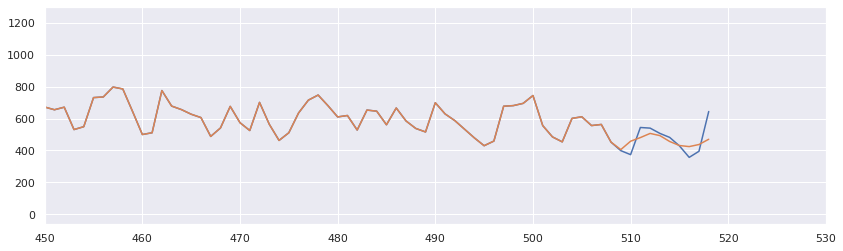

In [62]:
# train = raw_kor.iloc[:-10,:]
real4 = np.concatenate((raw_kor.iloc[:-10,:]['new_cases'], raw_kor.iloc[-10:,:]['new_cases']))
forecast4 = np.concatenate((raw_kor.iloc[:-10,:]['new_cases'], forecast["new_cases_forecasted"]))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real4, label = "real")
plt.plot(forecast4, label = "forecast")
plt.xlim([450,530])
plt.legend
plt.show()

<AxesSubplot:>

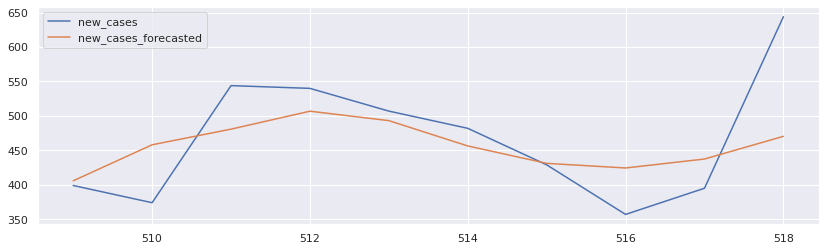

In [59]:
test = raw_kor.iloc[-10:,:1]
test["new_cases_forecasted"] = forecast["new_cases_forecasted"]

test.plot()

In [60]:
rmse = np.sqrt(mean_squared_error(test['new_cases'], test['new_cases_forecasted']))
rmse

70.39606376578098

# SEIR
